In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [5]:
newdf = pd.concat([df['Description'],df['Is_Response']],axis=1)

In [6]:
newdf.head()

,Description,Is_Response
0,The room was kind of clean but had a VERY stro...,not happy
1,I stayed at the Crown Plaza April -- - April -...,not happy
2,I booked this hotel through Hotwire at the low...,not happy
3,Stayed here with husband and sons on the way t...,happy
4,My girlfriends and I stayed here to celebrate ...,not happy


In [7]:
newdf.groupby('Is_Response').describe()

Description         \
                  count unique   
Is_Response                      
happy             26521  26521   
not happy         12411  12411   

                                                                     
                                                           top freq  
Is_Response                                                          
happy        I travel extensively, and can say I my expecta...    1  
not happy    I was robbed at this hotel # ---- by the clean...    1

In [8]:
newdf['Length'] = newdf['Description'].apply(len)

In [9]:
newdf.head()

,Description,Is_Response,Length
0,The room was kind of clean but had a VERY stro...,not happy,248
1,I stayed at the Crown Plaza April -- - April -...,not happy,1077
2,I booked this hotel through Hotwire at the low...,not happy,1327
3,Stayed here with husband and sons on the way t...,happy,502
4,My girlfriends and I stayed here to celebrate ...,not happy,1613


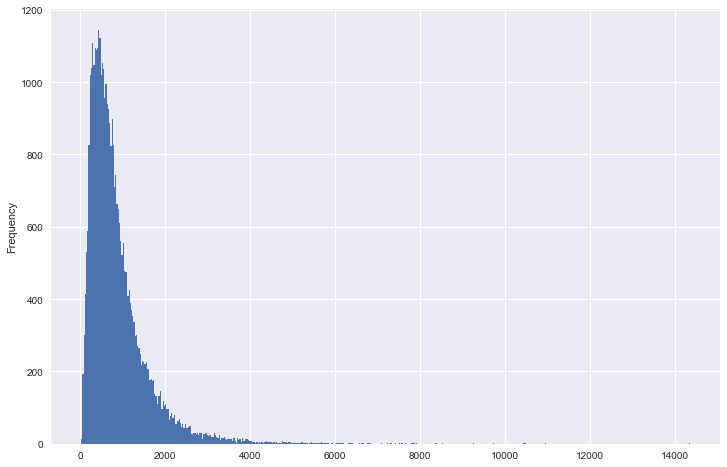

In [10]:
plt.figure(figsize=(12,8))
newdf['Length'].plot.hist(bins=500)

In [11]:
newdf['Length'].describe()

count    38932.000000
mean       866.276482
std        719.255343
min         20.000000
25%        405.000000
50%        676.000000
75%       1095.000000
max      14340.000000
Name: Length, dtype: float64

In [12]:
newdf[newdf['Length']==max(newdf['Length'])]['Description'].iloc[0]

'OVERVIEW: We will never stay here again or recommend this hotel to anyone. Noisy bedrooms not only from the invasive sound of people stomping about in the room above and using their bathroom......but from the bedroom air conditioning which sounds, relentlessly, like being on a jet taking off! Booked for - nights.....slept so badly due to noise we left one day early as my wife and I couldn\'t stand it......we would have left earlier if we could have done but best hotels fully booked due to Elvis Week. It had been up to -- degrees day of our final night and we needed to use the dreadful air conditioning hence lack of sleep. This hotel must have been cheaply constructed. The River Inn hotel seemed inhospitable from the moment we arrived.........in what had been a happy mood after a fantastic stay in Nashville at a spectacular hotel.....the reception staff we encountered at River Inn can hardly be bothered to even greet arriving guests......it\'s all business without a smile, """"""""""""

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000CA0816CF28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000CA08946CF8>], dtype=object)

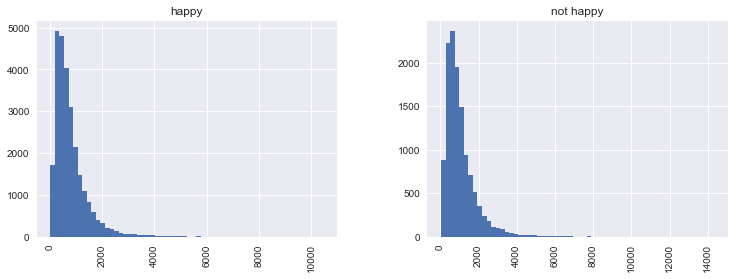

In [13]:
newdf.hist(column='Length',by='Is_Response',bins=60,figsize=(12,4))

In [14]:
import nltk
import string

In [15]:
from nltk.corpus import stopwords

In [16]:
def textprocess(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [17]:
newdf['Description'].head().apply(textprocess)

0    [room, kind, clean, strong, smell, dogs, Gener...
1    [stayed, Crown, Plaza, April, April, staff, fr...
2    [booked, hotel, Hotwire, lowest, price, could,...
3    [Stayed, husband, sons, way, Alaska, Cruise, l...
4    [girlfriends, stayed, celebrate, th, birthdays...
Name: Description, dtype: object

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
bow_transformer = CountVectorizer(analyzer=textprocess).fit(newdf['Description'])

In [20]:
print(len(bow_transformer.vocabulary_))

80055


In [21]:
desc_bow = bow_transformer.transform(newdf['Description'])

In [22]:
print('Shape of sparse matrix : ',desc_bow.shape)

Shape of sparse matrix :  (38932, 80055)


In [27]:
sparsity = (100.0 * desc_bow.nnz / (desc_bow.shape[0] * desc_bow.shape[1]))

In [28]:
print('Sparsity : {}'.format((sparsity)))

Sparsity : 0.08403314214336988


In [29]:
from sklearn.feature_extraction.text import TfidfTransformer

In [30]:
tfid_transformer = TfidfTransformer().fit(desc_bow)

In [31]:
desc_tfidf = tfid_transformer.transform(desc_bow)

In [32]:
from sklearn.naive_bayes import MultinomialNB

In [33]:
prediction_model = MultinomialNB().fit(desc_tfidf,newdf['Is_Response'])

In [34]:
all_pred = prediction_model.predict(desc_tfidf)

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
desc_train,desc_test,label_train,label_test = train_test_split(newdf['Description'],newdf['Is_Response'],test_size=0.3)

In [37]:
from sklearn.pipeline import Pipeline

In [39]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=textprocess)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [40]:
pipeline.fit(desc_train,label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function textprocess at 0x000000CA0F89D7B8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [41]:
predictions = pipeline.predict(desc_test)

In [42]:
from sklearn.metrics import classification_report,confusion_matrix

In [43]:
print(confusion_matrix(label_test,predictions))
print('\n')
print(classification_report(label_test,predictions))

[[7953   42]
 [2520 1165]]


             precision    recall  f1-score   support

      happy       0.76      0.99      0.86      7995
  not happy       0.97      0.32      0.48      3685

avg / total       0.82      0.78      0.74     11680



In [47]:
from sklearn.metrics import accuracy_score

In [48]:
print(accuracy_score(label_test,predictions))

0.780650684932
